# Apoapse Nightside Globe-Projection Quicklooks
Written by Zachariah Milby <br>
Created on July 10, 2019 <br>
Last modified on December 16, 2019<br>
<br>
Modified by Sonal Jain on 25 December to work with apoapse level2b files.

## Description
This code makes quicklook images from level 1B FITS files of MAVEN/IUVS nightside data. It creates a pixel grid of the data by overlaying the swaths, approximating the view of IUVS at MAVEN's apoapsis such that Mars appears as a circle/sphere. It also places a labeled grid of latitude and longitude lines on top of the data.

## Code

Here are the packages required for this code to run. Some may not be installed on your system by default (I'm looking at you, `cartopy`...)

In [2]:
# for math
import numpy as np

# for plotting and graphics display
import matplotlib.pyplot as plt
plt.rc('pdf', fonttype=42) #makes sure text isn't outlined when saved as PDF

# for placing an axis with a projection into another axis
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition

# for custom colormap creation and data scaling
import matplotlib.colors as colors

# for map projections and transforms
import cartopy.crs as ccrs

# for reading IDL SAV files
from scipy.io import readsav

# for reading FITS files
from astropy.io import fits

# for Linux-style file searching
import glob

# for SPICE nonsense
import spiceypy as spice
import glob
import os
import re

# for fitting
from sklearn import linear_model

SPICE shit.

In [3]:
spice_directory = '/Users/soja5284/IDLWorkspace/IUVS-ITF-SW/anc/spice/'
data_directory = '/Users/soja5284/IDLWorkspace/IUVS-ITF-SW/products/level1b/'
mvn_kpath = os.path.join(spice_directory, 'mvn')
generic_kpath = os.path.join(spice_directory, 'generic_kernels')
ck_path = os.path.join(mvn_kpath, 'ck')
spk_path = os.path.join(mvn_kpath, 'spk')

def find_latest_kernel(fnamelist_in, part, getlast=False, after=None):
    
    """
    Take a list of kernel file paths and return only the file paths to the latest versions of each kernel.
    
    Parameters
    ----------
    fnamelist_in : str, arr, list
        Input file path(s) of kernels.
    part : int
        I have no idea what this does yet.
    getlast : bool
        Set to true to return the date of the last of the latest kernels. Defaults to False.
    after : int
        Set to a date to get only kernels later than that date. Date format YYMMDD. Defaults to None.
    
    Returns
    -------
    retlist : list
        A list of file paths of the latest kernels.
    last : int
        The date of the last of the latest kernels. Format YYMMDD.
    """
    
    # store the input filename list internally
    fnamelist = fnamelist_in
    
    # if the filename list is not actually a list but just a single string, convert it to a list
    if type(fnamelist) == str:
        fnamelist = [fnamelist]
        
    # sort the list in reverse order so the most recent kernel appears first in a subset of kernels
    fnamelist.sort(reverse=True)
    
    # extract the filenames without their version number
    filetag = [os.path.basename(f).split("_v")[0] for f in fnamelist]
    
    # without version numbers, there are many repeated filenames, so find a single entry for each kernel
    uniquetags, uniquetagindices = np.unique(filetag, return_index=True)
    
    # make a list of the kernels with one entry per kernel
    fnamelist = np.array(fnamelist)[uniquetagindices]

    # extract the date portions of the kernel file paths
    datepart = [re.split('-|_', os.path.basename(fname))[part]
                for fname in fnamelist]
    
    # find the individual dates
    uniquedates, uniquedateindex = np.unique(datepart, return_index=True)
    
    # extract the finald ate
    last = uniquedates[-1]
    
    # make an empty list to store the latest kernel file paths
    retlist = []
    
    # if a date is chosen for after, then include only the latest kernels after the specified date
    if after is not None:
        retlist = [f for f, d in zip(
            fnamelist, datepart) if int(d) >= int(after)]
    
    # otherwise, return all the latest kernels
    else:
        retlist = [f for f, d in zip(fnamelist, datepart)]

    # if user wants, return also the date of the last of the latest kernels
    if getlast:
        return retlist, last
    
    # otherwise return just the latest kernels
    else:
        return retlist
    
def furnsh_array(kernel_array):
    
    """
    Furnish a set of kernels defined in a list or array of their file paths.
    
    Parameters
    ----------
    kernel_array : list, arr
        A list or array of kernel file paths.
    
    Returns
    -------
    None
    """
    
    [spice.furnsh(k) for k in kernel_array]
    
def load_sc_ck_type(kerntype, load_predicts=False, load_all_longterm=False):
    
    """
    Furnish CK kernels.
    
    Parameters
    ----------
    kerntype : str
        The type of CK kernel to furnish. We use 'app' and 'sc' with MAVEN/IUVS.
    load_predicts : bool
        Whether or not to load prediction kernels. Defaults to False.
    load_all_longterm : bool
        Whether or not to load all of the longterm kernels. Defaults to False, which loads only the last 10.
        
    Returns
    -------
    None
    """
    
    # load the long kernels first
    f = glob.glob(os.path.join(ck_path, 'mvn_' + kerntype + '_rel_*.bc'))
    lastlong = None
    if len(f) > 0:
        # use the second date in the week
        longterm_kernels, lastlong = find_latest_kernel(f, 4, getlast=True)

    # now the daily kernels
    f = glob.glob(os.path.join(ck_path, 'mvn_' + kerntype + '_red_*.bc'))
    lastday = None
    if len(f) > 0:
        day, lastday = find_latest_kernel(f, 3, after=lastlong, getlast=True)

    # finally the "normal" kernels
    f = glob.glob(os.path.join(ck_path, 'mvn_' + kerntype + '_rec_*.bc'))
    if len(f) > 0:
        norm = find_latest_kernel(f, 3, after=lastday)

    if load_predicts:
        # when we load predictions, they will go here
        f = glob.glob(os.path.join(ck_path, 'mvn_' + kerntype + '_pred_*.bc'))
        if len(f) > 0:
            pred_list = find_latest_kernel(f, 3, after=lastday)
            # use the last day, because normal kernels are irregular
            # use the second date, so if the prediction overlaps the last day, it gets loaded

    # unless the /all keyword is set, only load the last 10 long-term kernels
    if not load_all_longterm:
        longterm_kernels = longterm_kernels[-10:]

    # furnish things in the following order so that they are in proper
    # priority weekly has highest, then daily, then normal (then
    # predictions, if any) so load [pred,]norm,day,week
    furnsh_array(norm)
    furnsh_array(day)
    furnsh_array(longterm_kernels)
    if load_predicts:
        furnsh_array(pred_list)
        
def load_sc_ck(load_cruise=False, load_all_longterm=False):
    
    """
    Furnish CK kernels and mirror kernels, accounting for combined daily mirror kernels.
    
    Parameters
    ----------
    load_cruise : bool
        Whether or not to load kernels from cruise (when MAVEN was en route to Mars). Defaults to False.
    load_all_longterm : bool
        Whether or not to load all of the longterm kernels. Defaults to False, which loads only the last 10 
        (see function load_sc_ck_type).
    
    Returns
    -------
    None
    """
    
    # load orientation of Articulated Payload Platform (APP)
    load_sc_ck_type('app', load_all_longterm=load_all_longterm)
    
    # load spacecraft orientation
    load_sc_ck_type('sc', load_all_longterm=load_all_longterm)

    # Load the latest of each days' IUVS mirror kernel
    # Since the instrument was not active during September 2014 before MOI, we can consider
    # any kernel taken before September 1 2014 to be cruise, and any after to be in-orbit.
    f = []
    if load_cruise:
        # all the 2013 kernels
        this_f = glob.glob(os.path.join(ck_path,'mvn_iuv_all_l0_2013????_v*.bc'))
        f.extend(this_f)
        # all the 2014 cruise kernels
        this_f = glob.glob(mvn_kpath+'ck/mvn_iuv_all_l0_20140[1-8]??_v*.bc')
        f.extend(this_f)

    # Load only mirror kernels after the last combined mirror kernel in the meta kernel !ANC+"spice/mvn/mvn.tm"
    # Mid August 2017 kernels
    this_f = glob.glob(os.path.join(ck_path,'mvn_iuv_all_l0_2017081[56789]_v*.bc'))
    f.extend(this_f)
    # Late August 2017 kernels
    this_f = glob.glob(os.path.join(ck_path,'mvn_iuv_all_l0_201708[23]?_v*.bc'))
    f.extend(this_f)
    # September 2017 kernels
    this_f = glob.glob(os.path.join(ck_path,'mvn_iuv_all_l0_201709??_v*.bc'))
    f.extend(this_f)
    # Late 2017 kernels
    this_f = glob.glob(os.path.join(ck_path,'mvn_iuv_all_l0_20171???_v*.bc'))
    f.extend(this_f)
    # 2018-2019 kernels
    this_f = glob.glob(os.path.join(ck_path,'mvn_iuv_all_l0_201[89]????_v*.bc'))
    f.extend(this_f)

    if len(f) > 0:
        furnsh_array(find_latest_kernel(f, 4))
        
def load_sc_spk():
    
    """
    Furnish SPK kernels.
    
    Parameters
    ----------
    None
    
    Returns
    -------
    None
    """
    
    # retrieve list of SPK kernels
    f = glob.glob(os.path.join(spk_path,
                               'trj_orb_[0-9][0-9][0-9][0-9][0-9]-[0-9][0-9][0-9][0-9][0-9]_rec*.bsp'))
    
    # define lastorb for some reason
    lastorb = None
    
    # make an empty list to store kernel file paths
    rec = []
    
    # get the latest kernels and return the date of the last of the latest kernels
    if len(f) > 0:
        rec, lastorb = find_latest_kernel(f, 3, getlast=True)

    # get list of SPK prediction kernels
    f = glob.glob(os.path.join(spk_path,
                               'trj_orb_[0-9][0-9][0-9][0-9][0-9]-[0-9][0-9][0-9][0-9][0-9]_[0-9][0-9][0-9][0-9][0-9]*.bsp'))

    # make an empty list to store prediciton kernel file paths
    pred = []
    
    # get the latest prediction kernels only for those after the last of the non-prediction kernels
    if len(f) > 0:
        pred = find_latest_kernel(f, 4, after=lastorb)

    # furnish the prediction and non-prediction SPK kernels
    furnsh_array(pred)
    furnsh_array(rec)
    
def load_sc_sclk():
    
    """
    Furnish SCLK kernels.
    
    Parameters
    ----------
    None
    
    Returns
    -------
    None
    """
    
    # retrieve list of SCLK kernels
    f = glob.glob(os.path.join(mvn_kpath,'sclk','MVN_SCLKSCET.[0-9][0-9][0-9][0-9][0-9].tsc'))
    
    # sort the clock kernels
    f.sort()
    
    # furnish the clock kernels
    furnsh_array(f)
    
def breakup_path(string, splitlength):
    breakup = [string[i:i+splitlength]
               for i in range(len(string)//splitlength)]
    modlength = len(string) % splitlength
    if modlength == 0:
        return breakup
    else:
        breakup.append(string[-modlength:])
        return breakup
    
def load_iuvs_spice(load_all_longterm=False):
    
    """
    Load SPICE kernels for MAVEN/IUVS use.
    
    Parameters
    ----------
    spice_directory : str
        File path to local spice directory.
    load_all_longterm : bool
        Whether or not to load all of the longterm kernels. Defaults to False, which loads only the last 10 
        (see function load_sc_ck_type).
        
    Returns
    -------
    None
    """
    
    # A 'furnished' kernel is not the same thing as 'open' file. The
    # Spice library may but is not required to open any particular
    # file when it is furnished. Internally, it seems to have a
    # limited number of open file handles, and will close and reopen
    # files as it needs. In order to do this, either the current
    # directory must not change (not practical) or the full path of
    # the kernel must be specified. If neither of these happen, then
    # when the system tries to reopen a file, it only has the partial
    # path which is no longer valid.
    #
    # So what we do here is load the kernel into an IDL string. The
    # kernel must have a single path_values line. That line will be
    # replaced with a line specifying the full path (file_dirname() of
    # the metakernel). Then the metakernel string will be loaded.

    # clear any existing furnished kernels
    spice.kclear()
    
    # do whatever the hell this does, necessary to furnish the generic meta-kernel
    path_values = breakup_path(generic_kpath, 78)
    spice.pcpool('PATH_VALUES', path_values)
    spice.furnsh(generic_kpath+'/generic.tm')
    
    # again this thing, necessary to furnish the MAVEN meta-kernel
    path_values = breakup_path(mvn_kpath, 78)
    spice.pcpool('PATH_VALUES', path_values)
    spice.furnsh(mvn_kpath+'/mvn.tm')
    
    # furnish spacecraft C-kernels (attitude of spacecraft structures or instruments)
    load_sc_ck(load_all_longterm=load_all_longterm)
    
    # furnish SP-kernels (ephemeris data (spacecraft physical location))
    load_sc_spk()
    
    # furnish spacecraft clock kernels
    load_sc_sclk()

    # furnish some important kernel that does who-knows-what
    spice.furnsh(os.path.join(generic_kpath,'spk','mar097.bsp'))
    
    # determine how many kernels we've furnished, and warn if it's a lot
    count = spice.ktotal("ALL")
    if count > 800:
        print("Warning! " +str(count) +
              " of the allowed 1000 kernels have been furnished. Consider combining daily mirror kernels.")

The function `get_files` retrieves sorted lists of level 1B files for a chosen orbit number.

In [4]:
def get_files(orbit_number, segment='apoapse', channel='fuv', count=False):
    
    """
    Return file paths to FITS files for a given orbit number.
    
    Parameters
    ----------
    orbit_number : int
        Enough already. You're smarter than this.
    segment : str
        The orbit segment for which you want data files. Defaults to 'apoapse'.
    channel : str
        MUV and/or FUV channel.
    count : bool
        Whether or not to return the number of files.
    
    Returns
    -------
    files : array
        A sorted list of the file paths to the FITS files.
    n_files : int
        The number of files.
    """
    
    # determine orbit block
    orbit_block = int(orbit_number/100)*100
    
    # location of FITS files (this may change depending on the user)
    filepath = '/Volumes/Samsung_T5/level2b/orbit%.5d/' %(orbit_block)
    
    # format of FITS files
    if (channel == 'muv') | (channel == 'fuv'):
        filename_str = '*%s*orbit%.5d*%s*.fits.gz' %(segment, orbit_number, channel)
    elif channel == 'all':
        filename_str = '*%s*orbit%.5d*.fits.gz' %(segment, orbit_number)
    
    # get list of files
    files = sorted(glob.glob(filepath+filename_str))
    
    # get number of files
    n_files = int(len(files))
    
    # check to see if it was successful
    if n_files == 0:
        raise Exception('No files found. Check the data path and/or orbit number.')
    
    # return the list of files with the count if requested
    if count == False:
        return files
    else:
        return files, n_files

The function `MLR` takes an opened FITS file and fits the solar and NO nightglow spectra, returning the integrated MUV brightnesses.

In [5]:
def MLR(hdul):
    
    """
    Performs a nightside spectral MLR.
    
    Parameters
    ----------
    hdul : open FITS file
    
    Returns
    -------
    mlr_array : array
        Derived brightness values.
    """
    
    # extract the dimensions of the primary extension
    dims = np.shape(hdul['primary']) # get the dimensions of the primary extension
    n_integrations = dims[0] # number of integrations
    n_spatial = dims[1] # number of spatial bins along slit
    n_spectral = dims[2] # number of spectral bins
    
    # get the spectral wavelengths
    wavelength = hdul['observation'].data[0]['wavelength'][0]
    
    # this is Justin's DN threshold for valid data
    dn_threshold = 3600*4*16
    
    # determine wavelength index corresponding to fit start and length of fitting region
    if n_spectral == 40:
        fit_start = 32
        fit_length = n_spectral
    elif n_spectral == 174:
        fit_start = 17
        fit_length = n_spectral
        
    # load 256-spectral-bin templates
    templates = np.genfromtxt('Data/muv_templates.dat', skip_header=True)
    template_wavelength = templates[:,0][fit_start:fit_start+fit_length]
    calibration_curve = templates[:,1][fit_start:fit_start+fit_length]
    template_solar_continuum = templates[:,2][fit_start:fit_start+fit_length]
    template_co_cameron = templates[:,3][fit_start:fit_start+fit_length]
    template_co2uvd = templates[:,4][fit_start:fit_start+fit_length]
    template_o2972 = templates[:,5][fit_start:fit_start+fit_length]
    template_no_nightglow = templates[:,6][fit_start:fit_start+fit_length]
    template_constant = np.ones_like(template_solar_continuum)
    muv_features = ['Solar Continuum', 'CO Cameron Bands', 'CO2 UV Doublet', 'O(1S) 297.2 nm', 
                    'NO Nightglow', 'MUV Background']
    
    # determine spectral bin spacing
    dwavelength = np.diff(wavelength)[0]
    
    # make an array to hold regression coefficients
    mlr_array = np.zeros((dims[0],dims[1],3))*np.nan
    chisq_array = np.zeros((dims[0],dims[1]))*np.nan
    
    # loop through integrations
    for i in range(n_integrations):
        
        # loop through spatial bins
        for j in range(n_spatial):

            # extract the dark-subtracted detector image
            detector_image = hdul['detector_dark_subtracted'].data[i,j,:]

            # extract the error
            yerr = hdul['random_dn_unc'].data[i,j,:]

            # find all the data that are less than the DN threshold
            ygood = np.where(detector_image < dn_threshold)

            # make sure at least one point is good in order to perform the fit
            if np.size(ygood) != 0:

                X = np.array([template_solar_continuum[ygood],
                              template_no_nightglow[ygood]]).T
                Y = np.array(detector_image[ygood])
                yerr = yerr[ygood]
                
                lm = linear_model.LinearRegression()
                model = lm.fit(X,Y,sample_weight=(1/yerr)**2)
                coeff = model.coef_
                const = model.intercept_

                # integrate each component
                mlr_array[i,j,0] = np.trapz(coeff[0]*template_solar_continuum*calibration_curve, dx=dwavelength)
                mlr_array[i,j,1] = np.trapz(coeff[1]*template_no_nightglow*calibration_curve, dx=dwavelength)
                mlr_array[i,j,2] = np.trapz(const*template_constant*calibration_curve, dx=dwavelength)
    
    return mlr_array

The function `NO_cmap` defines a custom colormap for displaying nitric oxide (NO) data, based on IDL's color table #8. I can choose whether I want missing data to display as actually missing (transparent), or assign a color to it, in this case black or grey.

In [6]:
def NO_cmap(nan_color='none'):
    
    """
    Makes custom MAVEN/IUVS nitric oxide (NO) nightglow colormaps based on IDL color table #8.
    
    Parameters
    ----------
    nan_color : str
        The choice nan color. Current options available are none, black, and grey.
    
    Returns
    -------
    cmap : I have no idea
        Colormap with chosen nan color.
    """
    
    # color sequence from black -> green -> yellow-green -> white
    no_colors = [(0, 0, 0), (0, 0.5, 0), (0.61, 0.8, 0.2), (1, 1, 1)]
    
    if nan_color == 'none':
        
        # set colormap name
        cmap_name = 'NO'
        
        # make a colormap using the color sequence and chosen name
        cmap = colors.LinearSegmentedColormap.from_list(cmap_name, no_colors, N=2**8)
    
    if nan_color == 'black':
        
        # set colormap name
        cmap_name = 'NOBlack'
        
        # make a colormap using the color sequence and chosen name
        cmap = colors.LinearSegmentedColormap.from_list(cmap_name, no_colors, N=2**8)
        
        # set the nan color
        cmap.set_bad((0,0,0))
        
    if nan_color == 'grey':
        
        # set colormap name
        cmap_name = 'NOGrey'
        
        # make a colormap using the color sequence and chosen name
        cmap = colors.LinearSegmentedColormap.from_list(cmap_name, no_colors, N=2**8)
        
        # set the nan color
        cmap.set_bad((0.5,0.5,0.5))
        
    return cmap

The function `radiance_multiplier` appropriately-scales derived NO brightnesses accounting for the two different binning regimes. When there are 40 spectral bins, the given brightness is off by a factor of about 2.2.

In [7]:
def radiance_multiplier(radiance, spec_bin):
    
    """
    Scale 40-spectral-bin NO brightnesses.
    
    Parameters
    ----------
    radiance : float, array
        ,NO radiances in kilorayleigh (kR).
    spec_bin : int
        The number of spectral bins.
        
    Returns
    -------
    radiance : float, array
        NO radiances appropriately scaled. Same type/dimensions/physical units as radiance.
    """
    
    # check number of spectral bins and scale if 40
    if spec_bin == 40:
        radiance *= 2.20369
        
    # return the scaled (or unscaled) radiance
    return radiance

The function `beta_flip` determines whether a particular orbit took data under "beta-flip" conditions, when the APP rotates 180$^\circ$. If beta flipped, the slit direction is reversed, so the data grid has to be flipped along the horizontal axis.

In [8]:
def beta_flip(vi, vs):
    
    """ 
    Determine the spacecraft orientation and see if it underwent a beta flip. This compares the instrument 
    x-axis direction to the spacecraft velocity direction, which are either (nearly) parallel or anti-parallel.

    Parameters
    ----------
    vi : array, tuple
        Last vector [-1] of 'vx_instrument_inertial' from `spacecraftgeometry' in IUVS FITS file.
    vs : array, tuple
        Last vector [-1] of 'v_spacecraft_rate_inertial' from `spacecraftgeometry' in IUVS FITS file.

    Returns
    -------
    beta : bool
        Beta flipped? Yes or no, true or false...

    """
    
    # determine orientation between vectors
    app_sig = np.sign(np.dot(vi, vs))

    # if negative, then no beta flipping; if positive, then yes beta flipping
    if app_sig == -1:
        beta = False
    elif app_sig == 1:
        beta = True
    
    # return the bool
    return beta

The function `pixel_globe` generates the grid of pixels approximating the view of MAVEN/IUVS at apoapsis. I converted this from Sonal's IDL routine `globe_2.pro`. It presumes you will display the resulting data using `matplotlib.pyplot.pcolormesh`, so it returns a meshgrid of pixel locations along with the grid of pixel values. I hard coded the location where I store the custom apoapse L1B/L1C hybrid files (line 35).

In [9]:
def pixel_globe(orbit_number, valid=False):
    
    """
    Make a pixel grid of IUVS nightside swaths, approximating the view from MAVEN's apoapsis.
    
    Parameters
    ----------
    orbit_number : int
        I bet you can figure this one out...
    valid : bool
        If true (default), then it applies the pixel validation criteria developed by Nick, Sonal, and Zac
        in January 2019. If false, then it displays the data as observed, without any filtering of 
        cosmic rays, stray sunlight, SZA, etc.
    
    Returns
    -------
    x : array
        Horizontal pixel edges in kilometers from the center of Mars.
    y : array
        Vertical pixel edges in kilometers from the center of Mars.
    z : array
        Grid of projected pixel brightnesses.
    """
    
    # dimensions of pixel grid and width of a pixel in kilometers
    pixsize = 100 #20 #[km/pixel]
    xsize = int(8000/pixsize)
    ysize = int(8000/pixsize)

    # grid to hold sum of values falling in each pixel and a count of number of values in each pixel
    total = np.zeros((ysize,xsize))
    count = np.zeros((ysize,xsize))
    
    # list of FITS files for given orbit number with error handling
    files, n_files = get_files(orbit_number, count=True)
    if n_files == 0:
        raise ValueError('Invalid orbit number.')
        
    # variable to hold beta flip value
    flip = -1

    # loop through FITS files
    for f in range(len(files)):
        
        # open FITS file
        hdul = fits.open(files[f])
        
        # determine dimensions, and if it's a single integration, skip it
        dims = hdul['primary'].shape
        primary_array = hdul['primary'].data
        if len(dims) != 3:
            continue #skip single integrations
        n_int = dims[0]
        n_spa = dims[1]
        
        # also skip dayside
        if hdul['observation'].data['mcp_volt'] < 790:
            continue
        
        # get number of spectral bins
        spec_bin = np.shape(hdul['observation'].data['wavelength'][0][1])[0]
        
        # get vectors for determining beta flip
        if flip == -1:
            vi = hdul['spacecraftgeometry'].data['vx_instrument_inertial'][-1]
            vs = hdul['spacecraftgeometry'].data['v_spacecraft_rate_inertial'][-1]
            flip = beta_flip(vi,vs)
            
        # fit spectra
        #primary_array = MLR(hdul)

        # this is copied directly from Sonal; someday I'll figure it out and comment...
        # essentially it finds the place where the pixel position vector intersects the 400x400 grid
        # and places the pixel value in that location
        for i in range(n_int):
            vspc = hdul['spacecraftgeometry'].data[i]['v_spacecraft']
            vspcnorm = vspc/np.linalg.norm(vspc)
            vy = hdul['spacecraftgeometry'].data[i]['vy_instrument']
            vx = np.cross(vy, vspcnorm)

            for j in range(n_spa):
                primary = primary_array[i,j,1] #O1356
                solar = primary_array[i,j,0] #Lyman alpha
                const = primary_array[i,j,2] #O1304
                if spec_bin == 40:
                    solar_max = 1.15
                    const_max = 2.
                elif spec_bin == 174:
                    solar_max = 5.
                    const_max = 9.2
                    
                # if valid is true, then eliminate pixels which fail validation criteria
                if valid == True:
                    if (solar > solar_max) | (const > const_max):
                        continue
                    else:
                        #primary = radiance_multiplier(primary, spec_bin)
                        for m in range(4):
                            try:
                                vpix = hdul['pixelgeometry'].data[i]['pixel_vec']
                                vpixcorner = (np.squeeze(vpix[:,j,m]) + np.squeeze(vpix[:,j,4]))/2
                                vdiff = vspc - (np.dot(vspc,vpixcorner)*vpixcorner)
                                x = int(np.dot(vdiff,vx)*np.linalg.norm(vdiff) / np.linalg.norm([np.dot(vdiff,vx),np.dot(vdiff,vy)]) /pixsize+xsize/2)
                                y = int(np.dot(vdiff,vy)*np.linalg.norm(vdiff) / np.linalg.norm([np.dot(vdiff,vx),np.dot(vdiff,vy)]) /pixsize+ysize/2)
                                if (x >= 0) & (y >= 0):
                                    total[y,x] += primary
                                    count[y,x] += 1
                            except:
                                continue
                            
                # if validation turned off, then don't filter any pixels
                elif valid == False:
                    #primary = radiance_multiplier(primary, spec_bin)
                    for m in range(4):
                        try:
                            vpix = hdul['pixelgeometry'].data[i]['pixel_vec']
                            vpixcorner = (np.squeeze(vpix[:,j,m]) + np.squeeze(vpix[:,j,4]))/2
                            vdiff = vspc - (np.dot(vspc,vpixcorner)*vpixcorner)
                            x = int(np.dot(vdiff,vx)*np.linalg.norm(vdiff) / np.linalg.norm([np.dot(vdiff,vx),np.dot(vdiff,vy)]) /pixsize+xsize/2)
                            y = int(np.dot(vdiff,vy)*np.linalg.norm(vdiff) / np.linalg.norm([np.dot(vdiff,vx),np.dot(vdiff,vy)]) /pixsize+ysize/2)
                            if (x >= 0) & (y >= 0):
                                    total[y,x] += primary
                                    count[y,x] += 1
                        except:
                            continue
                        

    #calculate the average
    #total[np.where(count == 0)] = np.nan
    z = total/count
    
    # beta-flip if necessary
    if flip == True:
        z = np.fliplr(z)
    
    #make coordinate grids for each pixel in kilometers
    x, y = np.meshgrid(np.linspace(-xsize/2*pixsize, xsize/2*pixsize, xsize), np.linspace(-ysize/2*pixsize, ysize/2*pixsize, ysize))
    
    #return the coordinate grids and the spherically-projected data pixels
    return x, y, z

The function `mandp` draws latitude and longitude lines (meridians and parallels). I don't like the default method because it wont do labels in non-cylindrical projections, so I made my own.

It includes another function `double_transform` which overcomes a known text-placement bug in cartopy where a label with coordinates (nan,nan) shouldn't be visible because it isn't within the scope of the projection, but is instead placed at (0,0). This function checks to see if a label should be visible, and only places the label if it is.

In [10]:
def mandp(ax, transform, projection):
    
    # this function overcomes a known text placement bug in cartopy
    def double_transform(x, y, src, target, tol=2):
        rx, ry = target.transform_point(x, y, src)
        px, py = src.transform_point(rx, ry, target)
        if abs(x - px) < tol and abs(y - py) < tol:
            return rx, ry
        else:
            return None
    
    # make arrays of longitude/latitude values for meridian/parallel lines and labels
    dlon = 30 # spacing between longitudes
    longitudes = np.arange(-180,180+dlon,dlon)
    dlat = 30 # spacing between latitudes
    latitudes = np.arange(-90,90+dlat,dlat)
    
    # longitude lines and labels
    for i in longitudes:
        
        # plot longitude line
        line, = ax.plot(np.ones(1800)*i, np.linspace(-90,90,1800), color='white', linewidth=0.4, 
                transform=transform)
        
        # label longitude lines inbetween each parallel
        for j in latitudes[1:-1]:
            
            # check to see if label should be visible
            if double_transform(i, j+dlat/2, transform, projection):
                    
                    # place label at latitude + dlat/2
                    text = ax.text(i, j+dlat/2, r'$%i$' %i, color='white', transform=transform, 
                                       ha='center', va='center', bbox=dict(alpha=0))
    
    # latitude lines and labels
    for i in latitudes:
        
        # plot latitude line
        line, = ax.plot(np.linspace(-180,180,3600), np.ones(3600)*i, color='white', linewidth=0.4,
                transform=transform)
        
        # label latitude lines inbetween each meridian
        for j in longitudes:#[1:-1]:
            
            # check to see if label should be visible
            if double_transform(j+dlon/2, i, transform, projection):
                
                    # place the label at longitude + dlon/2
                    text = ax.text(j+dlon/2, i, r'$%i$' %i, color='white', transform=transform, 
                                       ha='center', va='center', bbox=dict(alpha=0))

The function `rotation_matrix` calculates the 3D counter-clockwise rotation matrix $\vec{M}$ around a given axis $(x_0,y_0,z_0)$ in Cartesian coordinates by some angle $\theta$ (in radians). To calculate the new position $\vec{v}'$ of a Cartesian vector $\vec{v}$, just calculate the dot-product of the rotation matrix with the vector: $\vec{v}' = \vec{M}\cdot\vec{v}$.

In [11]:
def rotation_matrix(axis, theta):
    
    """
    Return the rotation matrix associated with counterclockwise rotation about the given axis by theta radians.
    To transform a vector, calculate its dot-product with the rotation matrix.
    
    Parameters
    ----------
    axis : 3-element list, array, or tuple
        The rotation axis in Cartesian coordinates. Does not have to be a unit vector.
    theta : float
        The angle (in radians) to rotate about the rotation axis. Positive angles rotate counter-clockwise.
        
    Returns
    -------
    rotation_matrix : array with dimensions (3,3)
        The 3D rotation matrix.
    """
    
    # convert the axis to a numpy array and normalize it
    axis = np.array(axis)
    axis = axis / np.linalg.norm(axis)
    
    # calculate components of the rotation matrix elements
    a = np.cos(theta/2)
    b, c, d = -axis*np.sin(theta/2)
    aa, bb, cc, dd = a*a, b*b, c*c, d*d
    bc, ad, ac, ab, bd, cd = b*c, a*d, a*c, a*b, b*d, c*d
    
    # build the rotation matrix
    rotation_matrix = np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])
    
    # return the rotation matrix
    return rotation_matrix

The function `draw_grid` takes a given axis and places within it the perspective grid of latitude and longitude lines with labels.

In [12]:
# draws a grid of meridians and parallels from the perspective of MAVEN/IUVS at apoapsis
def draw_grid(ax, orbit_number):
    
    """
    Draw and label a grid of latitude and longitude lines as viewed by MAVEN/IUVS at apoapsis.
    
    Parameters
    ----------
    ax : matplotlib Artist
        The axis in which to draw the perspective grid of latitude and longitude lines.
    orbit_numer : int
        The orbit number for which to calculate the grid.
    
    Returns
    -------
    None.
    """
    
    # furnish SPICE kernels
    load_iuvs_spice()
    
    # calculate various parameters using SPICE
    files = get_files(orbit_number)
    hdul = fits.open(files[0])
    TIMFMT = 'YYYY-MON-DD HR:MN:SC.## (UTC) ::UTC ::RND'
    TIMLEN =  len(TIMFMT)
    target = 'Mars'
    frame = 'MAVEN_MME_2000'
    abcorr   = 'LT+S'
    observer = 'MAVEN'
    et_apr = [hdul['integration'].data['et'][0], hdul['integration'].data['et'][0]+4800.]
    cnfine = spice.utils.support_types.SPICEDOUBLE_CELL(2)
    spice.wninsd(et_apr[0], et_apr[1], cnfine)
    result = spice.utils.support_types.SPICEDOUBLE_CELL(100)
    spice.gfdist('Mars', 'none', observer, 'LOCMAX', 3396. + 6200., 0., 60., 100, cnfine, result=result)
    lr = spice.wnfetd(result, 0)
    left = lr[0]
    right = lr[1]
    strapotim = spice.timout(left, TIMFMT, TIMLEN)
    et_apoapse = spice.str2et(strapotim)
    state, ltime = spice.spkezr(target, et_apoapse, frame, abcorr, observer)
    spoint, trgepc, srfvec = spice.subpnt('Intercept: ellipsoid', target, et_apoapse, 'IAU_MARS', abcorr, observer)
    rpoint, colatpoint, lonpoint = spice.recsph(spoint)
    if lonpoint < 0.:
        lonpoint += 2*np.pi
    r_mars = 3396e3
    G = 6.673e-11*6.4273e23
    r = 1e3*state[0:3]
    v = 1e3*state[3:6]
    h = np.cross(r,v)
    n = h/np.linalg.norm(h)
    ev = np.cross(v,h)/G - r/np.linalg.norm(r)
    evn = ev/np.linalg.norm(ev)
    b = np.cross(evn,n)
    vb = np.dot(v,b)
    scx = np.cross(evn,n)
    
    # get the sub-spacecraft latitude and longitude, and altitude (converted to meters)
    sublat = 90 - np.degrees(colatpoint)
    sublon = np.degrees(lonpoint)
    if sublon > 180:
        sublon -= 360
    alt = np.sqrt(np.sum(srfvec**2))*1e3
    
    # north pole unit vector in the IAU Mars basis
    polar_vector = [0,0,1]
    
    # when hovering over the sub-spacecraft point unrotated (the meridian of the point is a straight vertical line, 
    # this is the exact view when using cartopy's NearsidePerspective or Orthographic with central_longitude and 
    # central latitude set to the sub-spacecraft point), calculate the angle by which the planet must be rotated 
    # about the sub-spacecraft point
    angle = np.arctan2(np.dot(polar_vector,-b), np.dot(polar_vector,n))

    # first, rotate the pole to a different latitude given the subspacecraft latitude
    # cartopy's RotatedPole uses the location of the dateline (-180) as the lon_0 coordinate of the north pole
    pole_lat = 90+sublat
    pole_lon = -180

    # convert pole latitude to colatitude (for spherical coordinates)
    # also convert to radians for use with numpy trigonometric functions
    phi = pole_lon*np.pi/180
    theta = (90-pole_lat)*np.pi/180
    
    # calculate the Cartesian vector pointing to the pole
    polar_vector = [np.cos(phi)*np.sin(theta), np.sin(phi)*np.sin(theta), np.cos(theta)]
    
    # by rotating the pole, the observer's sub-point in cartopy's un-transformed coordinates is (0,0)
    # the rotation axis is therefore the x-axis
    rotation_axis = [1,0,0]
    
    # rotate the polar vector by the calculated angle
    rotated_polar_vector = np.dot(rotation_matrix(rotation_axis, -angle), polar_vector)
    
    # get the new polar latitude and longitude after the rotation, with longitude offset to dateline
    rotated_polar_lon = np.arctan(rotated_polar_vector[1]/rotated_polar_vector[0])*180/np.pi - 180
    rotated_polar_lat = 90 - np.arccos(rotated_polar_vector[2]/np.linalg.norm(rotated_polar_vector))*180/np.pi

    # calculate a RotatedPole transform for the rotated pole position
    transform = ccrs.RotatedPole(pole_latitude=rotated_polar_lat, pole_longitude=rotated_polar_lon, central_rotated_longitude=0)
    
    # transform the viewer (0,0) point
    tcoords = transform.transform_point(0, 0, ccrs.PlateCarree())
    
    # find the angle by which the planet needs to be rotated about it's rotated polar axis and calculate a new 
    # RotatedPole transform including this angle rotation
    rot_ang = sublon-tcoords[0]
    transform = ccrs.RotatedPole(pole_latitude=rotated_polar_lat, pole_longitude=rotated_polar_lon, central_rotated_longitude=rot_ang)

    # make a cartopy globe with the radius of Mars and a NearsidePerspective projection, centered above (0,0), with
    # a viewer altitude at the spacecraft's altitude
    R_Mars = 3.3895e6 #[m]
    globe = ccrs.Globe(semimajor_axis=R_Mars, semiminor_axis=R_Mars)
    projection = ccrs.NearsidePerspective(central_latitude=0, central_longitude=0, satellite_height=alt, globe=globe)

    # make sure the original axis is equal-aspect
    ax.set_aspect('equal')
    
    # make a new axis on top of the one with the green data grid
    ax1 = plt.axes([0,0,1,1], projection=projection)
    corner_pos = (1-R_Mars/4e6)/2
    bbox = [corner_pos, corner_pos, 1-2*corner_pos, 1-2*corner_pos]
    ax1.set_axes_locator(InsetPosition(ax, bbox))
    
    # turn off the circular outline of the projection and the opaque background
    ax1.patch.set_visible(False)
    ax1.outline_patch.set_visible(False)
    ax1.background_patch.set_visible(False)

    # draw and label meridians and parallels
    mandp(ax1, transform, projection)

The final function `apoapse_globe_quicklook` brings it all together and actually makes the quicklook image. I've set square-root scaling (`matplotlib.colors.PowerNorm()` uses gamma-scaling, where gamma is the exponent to which the data are raised before display). I've hard coded things like the DPI and dimensions of the saved image, but you can easily change this if you want higher resolution. I've also set the color scaling for 0 to 2 kR, so it's consistent image-to-image.

In [23]:
def apoapse_globe_quicklook(orbit_number):
    
    # make a figure
    fig = plt.figure(figsize=(5,5))
    
    # make axes to hold the pixel data grid and turn off the box, axis labels, etc.
    ax = plt.axes([0,0,1,1])
    ax.axis('off')
    
    # calculate the pixel data grid
    x, y, z = pixel_globe(orbit_number)
    
    # display the pixel data grid using the colormap
    img = ax.pcolormesh(x, y, z, cmap=NO_cmap('black'), norm=colors.PowerNorm(gamma=1/2, vmin=0, vmax=1.4))
    #cb = ax.colorbar()

    # draw and the meridian/parallel grid
    draw_grid(ax, orbit_number)

    # show the figure
    plt.savefig('apoapse_globe_orbit%.5d.png' %(orbit_number), dpi=300)

Make a quicklook to test.

/Users/soja5284/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:130: RuntimeWarning: invalid value encountered in true_divide


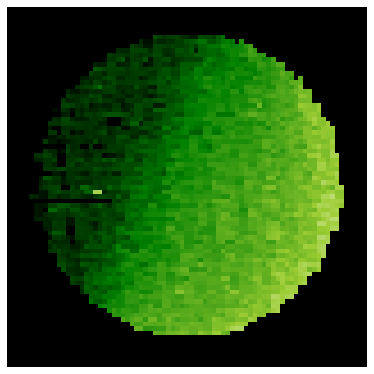

In [22]:
apoapse_globe_quicklook(3800)